### Thien Win
BrainStation Data Science Capstone <br>
April 2022 <br>

</br>

##### Notebook Table of Contents: <br>
[1] Data Scraping and Wrangling <br>
[2] CycleGAN Training <br>
<b>[3] Model Evaluation </b><br>
[4] FID Score <br>
<hr>

### [3] Model Evaluation

##### Recommended Computing: Local Machine

<hr>

#### Introduction

At the conclusion of the previous notebook `[2] CycleGAN Training`, we've completed the training of the model for 100 epochs. We've also generated some sample images after the training to ensure that the model is at least generating images that differs from the source image. 

While we were successful in that endeavor, we want to investigate whether training up to 100 epochs produced superior results as to less training. From the verbose output of the training, I created a Training_VerboseOutput.csv file to be imported and evaluated in this notebook.

From my initial hypothesis, I would expect that as the training progresses, the generator and the discriminator loss functions would decrease as they get better at their respective tasks of generating images and discerning real from fakes. I would expect that in the later training epochs, the improvement rate to either network would be minimal. 

In [1]:
#import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from cycleGAN_functions import *
import os

In [2]:
losses = pd.read_csv('Training_VerboseOutput.csv')
losses

Epoch 1/100
0    1536/1536 [==============================] - 3...
1                                          Epoch 2/100
2    1535/1536 [============================>.] - E...
3    Epoch 2: saving model to /content/train/train-...
4    1536/1536 [==============================] - 3...
..                                                 ...
294  1536/1536 [==============================] - 3...
295                                      Epoch 100/100
296  1535/1536 [============================>.] - E...
297  Epoch 100: saving model to /content/train/trai...
298  1536/1536 [==============================] - 3...

[299 rows x 1 columns]

#### Post Training Data Extraction

From the imported file as shown above, we can see that it is not really usable for analysis purposes. We first need to clean and extract information from this dataframe. Using the actual csv file as reference, we can see that before the model saves at every other epoch, there is a verbose printout at step `1535/1536`. In addition, let's create a separate column for just the epoch counting and remove the verbose epoch rows. We can use this to remove these unneccessary rows.

In [3]:
#redefine losses df from original including rows that DO NOT include '1783/1784'
losses = losses[losses['Epoch 1/100'].str.contains('1535/1536')==False]

#redefine losses df from original including rows that DO NOT include 'Epoch'
losses = losses[losses['Epoch 1/100'].str.contains('Epoch')==False]

#create a new column for epoch counting
losses['Epoch'] = range(1,101)

#set new epoch column as index
losses.set_index('Epoch', inplace=True)

losses

Epoch 1/100
Epoch                                                   
1      1536/1536 [==============================] - 3...
2      1536/1536 [==============================] - 3...
3      1536/1536 [==============================] - 3...
4      1536/1536 [==============================] - 3...
5      1536/1536 [==============================] - 3...
...                                                  ...
96     1536/1536 [==============================] - 3...
97     1536/1536 [==============================] - 3...
98     1536/1536 [==============================] - 3...
99     1536/1536 [==============================] - 3...
100    1536/1536 [==============================] - 3...

[100 rows x 1 columns]

As can be seen, we have reduced the rows to the 100 training observations by removing the unnecessary verbose printout. We will now extract the `SG_gen_loss`, `photo_gen_loss`, `SG_disc_loss`, and `photo_disc_loss` and save the information into respective columns. We will accomplish this by utilizing a split method to look for the sought after data.

Let's first run a test to see how the information is split by performing it on the first row.

In [4]:
#split the long string with a delimiter of '-'
test = losses['Epoch 1/100'][1]
test.split('-')

['1536/1536 [==============================] ',
 ' 380s 244ms/step ',
 ' SG_gen_loss: 3.4807 ',
 ' photo_gen_loss: 3.3197 ',
 ' SG_disc_loss: 0.5657 ',
 ' photo_disc_loss: 0.6243']

In [5]:
test = losses['Epoch 1/100'][1]
test = test.split('-')[2]
test

' SG_gen_loss: 3.4807 '

From the split test above, we see that the desired information is located at index 2-5. We can pull out this information and create new columns for this information.

In [6]:
#split the verbose by '-' and assign respective info to column by index
separated = losses['Epoch 1/100'].str.split('-', n=-1, expand=True)

losses['SG_gen_loss'] = separated[2]
losses['photo_gen_loss'] = separated[3]
losses['SG_disc_loss'] = separated[4]
losses['photo_disc_loss'] = separated[5]

losses

Epoch 1/100  \
Epoch                                                      
1      1536/1536 [==============================] - 3...   
2      1536/1536 [==============================] - 3...   
3      1536/1536 [==============================] - 3...   
4      1536/1536 [==============================] - 3...   
5      1536/1536 [==============================] - 3...   
...                                                  ...   
96     1536/1536 [==============================] - 3...   
97     1536/1536 [==============================] - 3...   
98     1536/1536 [==============================] - 3...   
99     1536/1536 [==============================] - 3...   
100    1536/1536 [==============================] - 3...   

                 SG_gen_loss            photo_gen_loss  \
Epoch                                                    
1       SG_gen_loss: 3.4807    photo_gen_loss: 3.3197    
2       SG_gen_loss: 3.4043    photo_gen_loss: 3.1756    
3       SG_gen_loss: 3.3929    photo_gen_loss: 3.1489    
4       SG_gen_loss: 3.2750    photo_gen_loss: 3.0915    
5       SG_gen_loss: 3.1803    photo_gen_loss: 3.0109    
...                      ...                       ...   
96      SG_gen_loss: 4.8807    photo_gen_loss: 3.1313    
97      SG_gen_loss: 4.8209    photo_gen_loss: 3.1307    
98      SG_gen_loss: 4.7568    photo_gen_loss: 3.1233    
99      SG_gen_loss: 4.8586    photo_gen_loss: 3.1219    
100     SG_gen_loss: 4.9265    photo_gen_loss: 3.1499    

                 SG_disc_loss           photo_disc_loss  
Epoch                                                    
1       SG_disc_loss: 0.5657    photo_disc_loss: 0.6243  
2       SG_disc_loss: 0.5345    photo_disc_loss: 0.6137  
3       SG_disc_loss: 0.5347    photo_disc_loss: 0.6025  
4       SG_disc_loss: 0.5435    photo_disc_loss: 0.5964  
5       SG_disc_loss: 0.5480    photo_disc_loss: 0.5981  
...                       ...                       ...  
96      SG_disc_loss: 0.2611    photo_disc_loss: 0.5516  
97      SG_disc_loss: 0.2606    photo_disc_loss: 0.5504  
98      SG_disc_loss: 0.2668    photo_disc_loss: 0.5479  
99      SG_disc_loss: 0.2592    photo_disc_loss: 0.5537  
100     SG_disc_loss: 0.2483    photo_disc_loss: 0.5497  

[100 rows x 5 columns]

We are getting getting closer to the desired dataframe. As a last step, we will the original column `Epoch 1/100` and the redundant column name inclusion in the other columns.

In [7]:
#drop column
losses = losses.drop(columns='Epoch 1/100')

#drop verbose column name in observations
losses['SG_gen_loss'] = losses['SG_gen_loss'].str.replace('SG_gen_loss:', '')
losses['photo_gen_loss'] = losses['photo_gen_loss'].str.replace('photo_gen_loss:', '')
losses['SG_disc_loss'] = losses['SG_disc_loss'].str.replace('SG_disc_loss:', '')
losses['photo_disc_loss'] = losses['photo_disc_loss'].str.replace('photo_disc_loss:', '')

losses

SG_gen_loss photo_gen_loss SG_disc_loss photo_disc_loss
Epoch                                                        
1         3.4807         3.3197       0.5657           0.6243
2         3.4043         3.1756       0.5345           0.6137
3         3.3929         3.1489       0.5347           0.6025
4         3.2750         3.0915       0.5435           0.5964
5         3.1803         3.0109       0.5480           0.5981
...           ...            ...          ...             ...
96        4.8807         3.1313       0.2611           0.5516
97        4.8209         3.1307       0.2606           0.5504
98        4.7568         3.1233       0.2668           0.5479
99        4.8586         3.1219       0.2592           0.5537
100       4.9265         3.1499       0.2483           0.5497

[100 rows x 4 columns]

Since we extracted the information from a string originally, the data will still be a string. This can be confirmed by checking the datatypes of the cleaned up dataframe.

In [8]:
losses.dtypes

SG_gen_loss        object
photo_gen_loss     object
SG_disc_loss       object
photo_disc_loss    object
dtype: object

We will recast the datatypes to be floats so that we can perform numeric analysis on the dataframe.

In [9]:
losses = losses[['SG_gen_loss','photo_gen_loss','SG_disc_loss','photo_disc_loss']].astype('float')

In [10]:
losses.dtypes

SG_gen_loss        float64
photo_gen_loss     float64
SG_disc_loss       float64
photo_disc_loss    float64
dtype: object

Now that we have out losses dataframe in order and usable, we can begin some analysis 
<hr>

#### Post Training Analysis

We want to start by identifying where the maximum and minimum generator loss occurs. A low generator loss signifies that the generator produced a better "fake" image based on how the discriminator classifies the generated image. A higher generator loss is the opposite.

We start by identifying the epoch and value of the minimized generator loss.

In [11]:
#smallest sg generator loss index
min_epoch_gen_loss = losses[['SG_gen_loss']].idxmin()[0]

#smallest sg generator loss value
min_gen_loss = losses['SG_gen_loss'].min()

print('Minimum SG Generator Loss:')
print('Epoch =',min_epoch_gen_loss, '' ,'Value =', min_gen_loss)

Minimum SG Generator Loss:
Epoch = 12  Value = 3.1224


We can see that at Epoch 12, the generator loss is minimized. This is surprising and differs from my initial assumption of continued generator loss improvement through increased training. 

Let's take a look at the maximum generator loss occurrence:

In [12]:
#smallest sg generator loss index
max_epoch_gen_loss = losses[['SG_gen_loss']].idxmax()[0]

#smallest sg generator loss value
max_gen_loss = losses['SG_gen_loss'].max()

print('Maximum SG Generator Loss:')
print('Epoch =',max_epoch_gen_loss, '' ,'Value =', max_gen_loss)

Maximum SG Generator Loss:
Epoch = 100  Value = 4.9265


The highest generator loss was observed at the last epoch of the training and goes against the initial hypothesis of decreased generator loss through training.

We can observe the generator loss over the training epochs as follows:

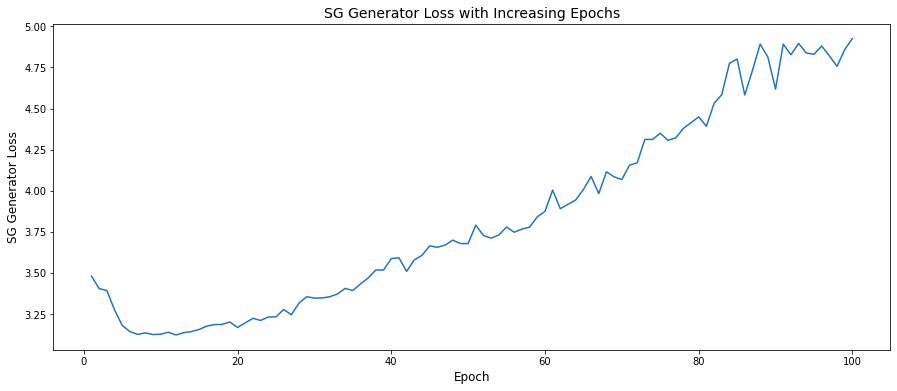

In [13]:
#plot SG gen loss
plt.figure(figsize=(15,6))
plt.plot(losses['SG_gen_loss'])
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('SG Generator Loss', fontsize=12)
plt.title('SG Generator Loss with Increasing Epochs', fontsize=14)
plt.show()

From the plot above, we see that after epoch 10, the generator loss generally increases for the remainder of the training.
 
Let's now take a look at the discriminator loss function throughout the training. As the discriminator is trained, it is expected to get better at classifying fake images. We start by identifying the occurrence of the minimum and maximum values of the discriminator loss and the corresponding index.

In [14]:
#smallest sg disc loss index
min_epoch_disc_loss = losses[['SG_disc_loss']].idxmin()[0]

#smallest sg generator loss value
min_disc_loss = losses['SG_disc_loss'].min()

print('Minimum SG Discriminator Loss:')
print('Epoch =',min_epoch_disc_loss, '' ,'Value =', min_disc_loss)

Minimum SG Discriminator Loss:
Epoch = 91  Value = 0.2481


In [15]:
#highest sg disc loss index
max_epoch_disc_loss = losses[['SG_disc_loss']].idxmax()[0]

#highest sg generator loss value
max_disc_loss = losses['SG_disc_loss'].max()

print('Maximum SG Discriminator Loss:')
print('Epoch =',max_epoch_disc_loss, '' ,'Value =', max_disc_loss)

Maximum SG Discriminator Loss:
Epoch = 1  Value = 0.5657


We can also from the print out above that the maximum discriminator loss occurs right in the beginning of the training and the minimum at the end. We can further visualize this in a plot:

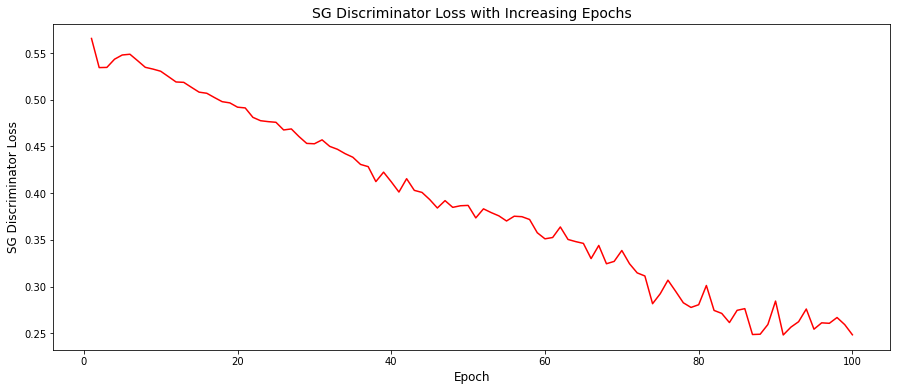

In [16]:
#plot SG disc loss
plt.figure(figsize=(15,6))
plt.plot(losses['SG_disc_loss'], c='r')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('SG Discriminator Loss', fontsize=12)
plt.title('SG Discriminator Loss with Increasing Epochs', fontsize=14)
plt.show()

From the plot above, as the training continues, the discriminator loss decreases meaning it gets better at classifying fakes and aligns with the initial hypothesis of continued improvement. 

This could be better visualized by comparing both model performances on a single plot as shown below.

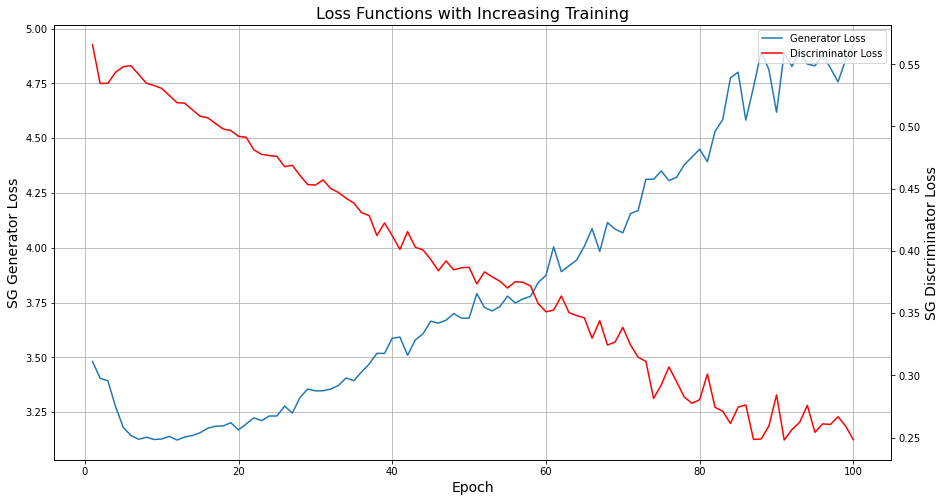

In [17]:
fig,ax = plt.subplots(figsize=(15,8))

gen_loss = ax.plot(losses['SG_gen_loss'], label='Generator Loss')
ax2=ax.twinx()
disc_loss = ax2.plot(losses['SG_disc_loss'], c='r', label='Discriminator Loss')

lns = gen_loss+disc_loss
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=1)

ax.grid()
plt.title('Loss Functions with Increasing Training', fontsize=16)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('SG Generator Loss', fontsize=14)
ax2.set_ylabel('SG Discriminator Loss', fontsize=14)

plt.show()

In [18]:
losses.iloc[58]

SG_gen_loss        3.8415
photo_gen_loss     2.8547
SG_disc_loss       0.3576
photo_disc_loss    0.5863
Name: 59, dtype: float64

The combined plot above summarizes the findings. Though the discriminator continues to improve through increased training, the generator quickly improves early in the training process (< epoch 10) and reaches it minimum at epoch 10. It then actually gets worse at generating images the more it is trained.

Failure to converge
<hr>

#### Sample Images 

Recognizing the issue of a non-converging model, I will continue with the model and associated checkpoints to evaluate the generated images. Referring to the training performed in notebook `[2] CycleGAN Training`, I had saved the model weights every other epoch. I will compare the weights for the different levels of training and the produced images from the generator at epochs 12, 58 and 100. 

In [2]:
#create dataset from test photos
test_photo = tf.keras.utils.image_dataset_from_directory(
        'data/photos/testB',
        labels=None,
        label_mode=None,
        class_names=None,
        color_mode='rgb',
        batch_size=None,
        image_size=(256,256),
        shuffle=True,
        seed=123,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=True,
        crop_to_aspect_ratio=False
    )

Found 751 files belonging to 1 classes.


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
BATCH_SIZE = 1

test_photo = test_photo.map(
    preprocess_test_photo, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

I will define a set of 6 images first to subjectively compare the results from the different level of trainings.

In [56]:
#create list so we can iterate through easier
example_photo = []
for i in range(6):
    example_photo.append(next(iter(test_photo)))

In [4]:
example_photo_all = []
for i in range(751):
    example_photo_all.append(next(iter(test_photo)))

The original randomly selected photos are as follows:

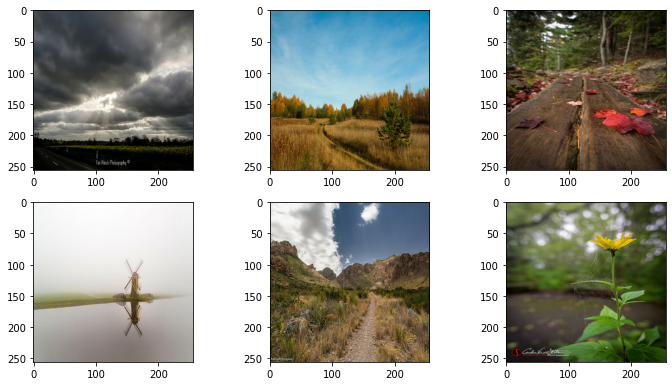

In [57]:
plt.figure(figsize=(12,10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.imshow(tf.keras.utils.array_to_img(example_photo[i][0], data_format=None, scale=True, dtype=None))
plt.show()

From the `cycleGAN_model.py` file, I will import the cycleGAN model structure and compile it so that the weights can be loaded into the model as follows:

In [6]:
from cycleGAN_model import *

In [7]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        SG_generator, photo_generator, SG_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        SG_gen_optimizer = SG_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        SG_disc_optimizer = SG_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

I will load the saved weights from epoch 12, 58 and 100 into the cycleGAN model. From there, the same photographs as defined before will be used in each generator with different training levels and compared side by side to judge the images subjectively.

In [60]:
#load in different weights and produce save test images
checkpoint_path12 = 'training_ckpts/train-0012.ckpt'

#Epoch 12
cycle_gan_model.load_weights(checkpoint_path12)

#create list so we can iterate through easier
to_SG_test12 = []
for i in range(6):
    to_SG_test12.append(SG_generator(example_photo[i]))

In [8]:
#create directory to place all generated images for specific gen
os.makedirs('generated_imgs/epoch12')

#generating images for all test photos to be used for FID eval
for i in range(751):
    generated_img = SG_generator(example_photo_all[i])
    sg12_photo = tf.keras.utils.array_to_img(generated_img[0], data_format=None, scale=True, dtype=None)
    tf.keras.utils.save_img(f'generated_imgs/epoch12/sg12_{i}.jpg', sg12_photo)

In [61]:
#load in different weights and produce save test images
checkpoint_path58 = 'training_ckpts/train-0058.ckpt'

#Epoch 58
cycle_gan_model.load_weights(checkpoint_path58)

#create list so we can iterate through easier
to_SG_test58 = []
for i in range(6):
    to_SG_test58.append(SG_generator(example_photo[i]))

In [9]:
#create directory to place all generated images for specific gen
os.makedirs('generated_imgs/epoch58')

#generating images for all test photos to be used for FID eval
for i in range(751):
    generated_img = SG_generator(example_photo_all[i])
    sg58_photo = tf.keras.utils.array_to_img(generated_img[0], data_format=None, scale=True, dtype=None)
    tf.keras.utils.save_img(f'generated_imgs/epoch58/sg58_{i}.jpg', sg58_photo)

In [62]:
#load in different weights and produce save test images
checkpoint_path100 = 'training_ckpts/train-0100.ckpt'

#Epoch 100
cycle_gan_model.load_weights(checkpoint_path100)

#create list so we can iterate through easier
to_SG_test100 = []
for i in range(6):
    to_SG_test100.append(SG_generator(example_photo[i]))

In [10]:
#create directory to place all generated images for specific gen
os.makedirs('generated_imgs/epoch100')

#generating images for all test photos to be used for FID eval
for i in range(751):
    generated_img = SG_generator(example_photo_all[i])
    sg100_photo = tf.keras.utils.array_to_img(generated_img[0], data_format=None, scale=True, dtype=None)
    tf.keras.utils.save_img(f'generated_imgs/epoch100/sg100_{i}.jpg', sg100_photo)

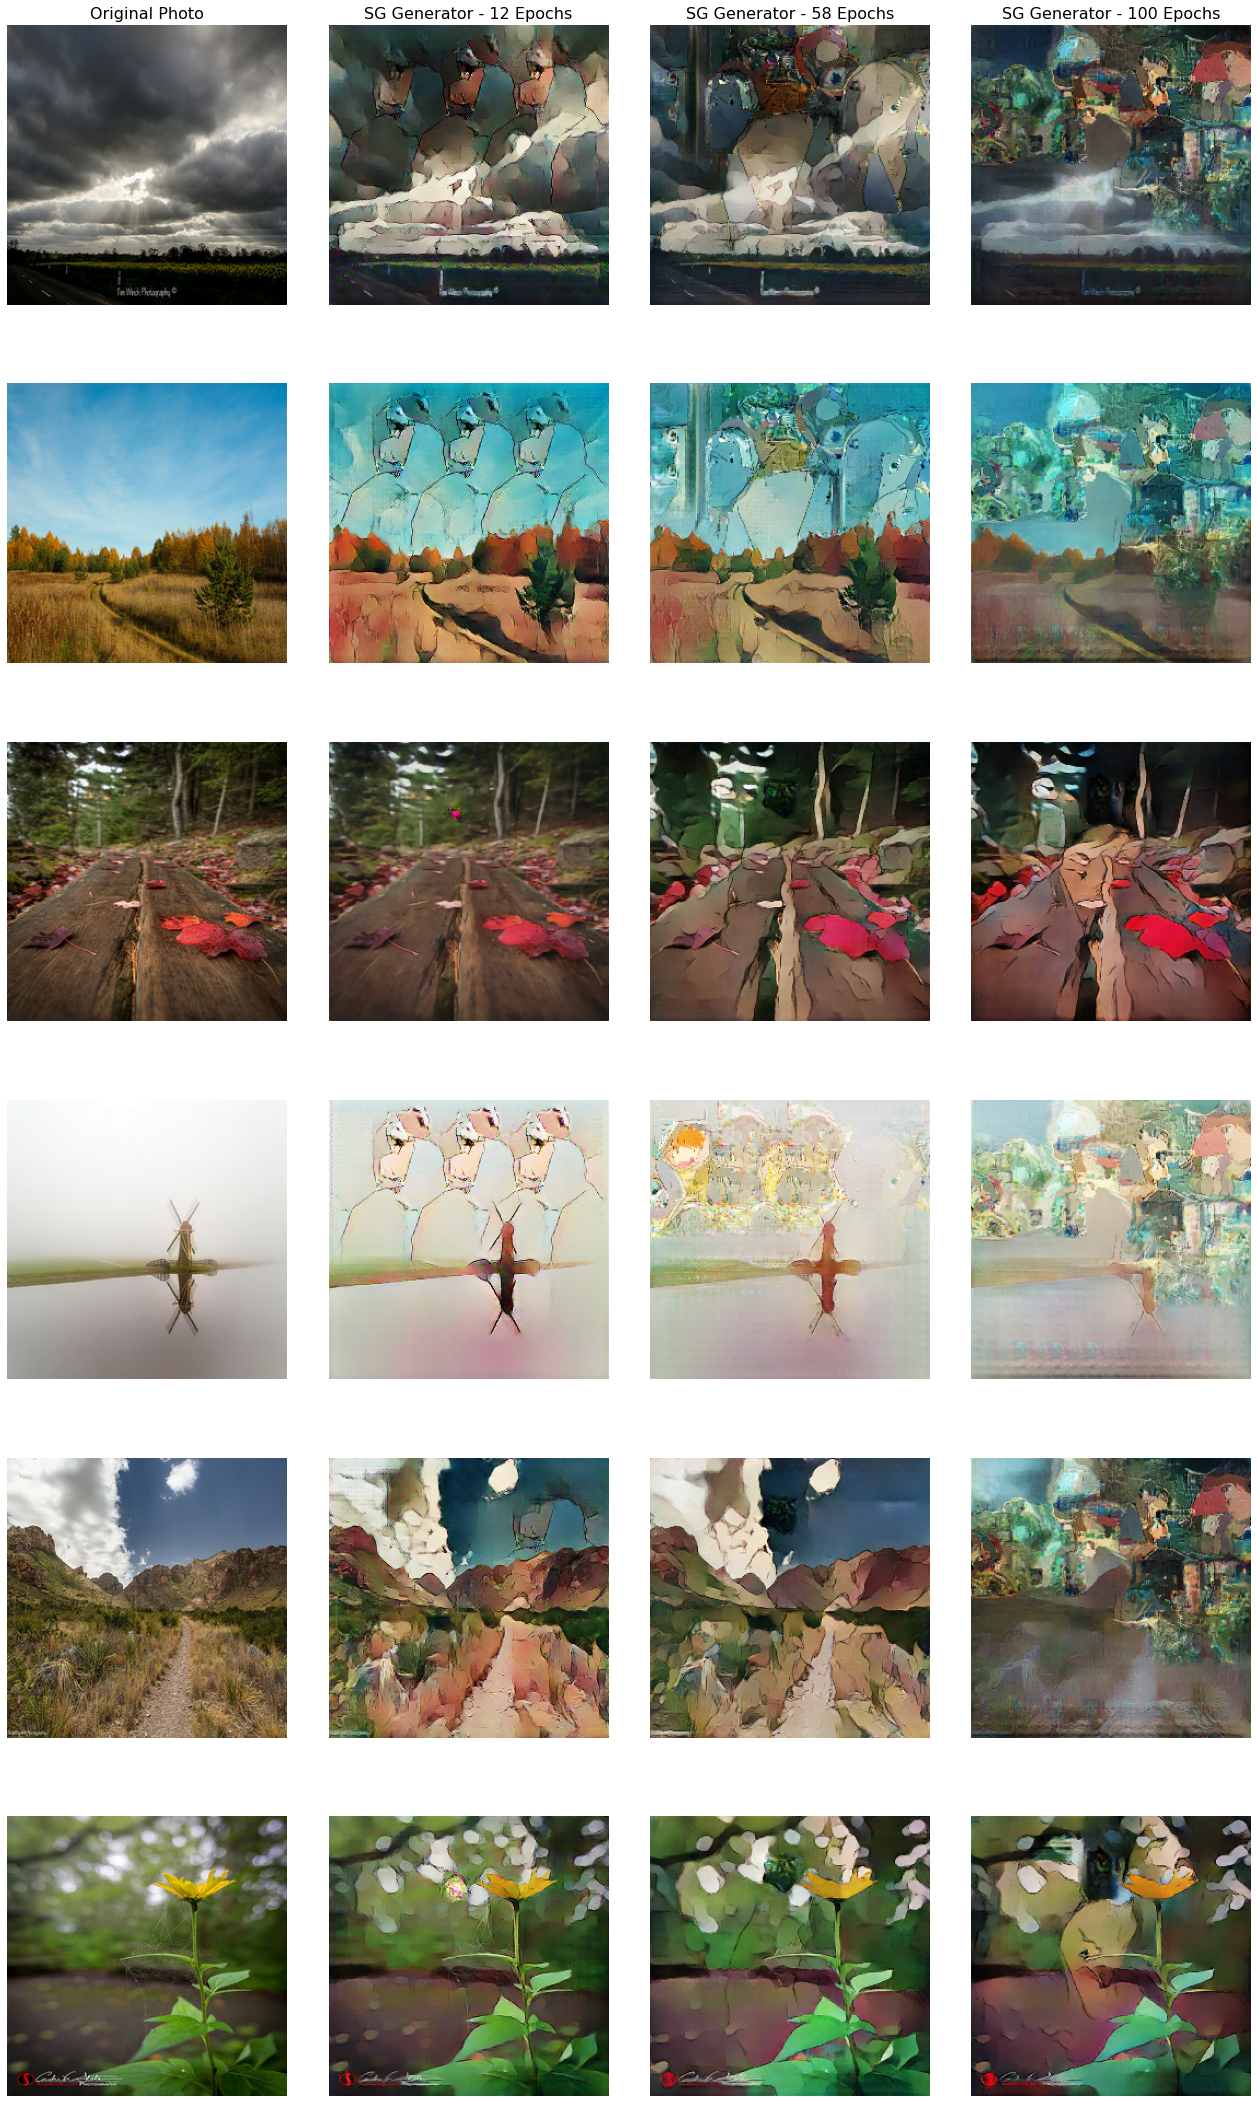

In [63]:
fig, ax = plt.subplots(6, 4, figsize=(18,30))
fig.tight_layout()

ax[0, 0].set_title("Original Photo", fontsize=16)
ax[0, 1].set_title("SG Generator - 12 Epochs", fontsize=16)
ax[0, 2].set_title("SG Generator - 58 Epochs", fontsize=16)
ax[0, 3].set_title("SG Generator - 100 Epochs", fontsize=16)

for i in range(6):
    #create subplots
    ax[i, 0].imshow(tf.keras.utils.array_to_img(example_photo[i][0], data_format=None, scale=True, dtype=None))
    ax[i, 0].axis('off')

    ax[i, 1].imshow(tf.keras.utils.array_to_img(to_SG_test12[i][0], data_format=None, scale=True, dtype=None))
    ax[i, 1].axis('off')
    
    ax[i, 2].imshow(tf.keras.utils.array_to_img(to_SG_test58[i][0], data_format=None, scale=True, dtype=None))
    ax[i, 2].axis('off')
    
    ax[i, 3].imshow(tf.keras.utils.array_to_img(to_SG_test100[i][0], data_format=None, scale=True, dtype=None))
    ax[i, 3].axis('off')
    
plt.show()

<hr>

#### Conclusion

From the sample images and associated generator transformations, it is difficult to determine which level of training produced the best quality images. There can be discrepancies in subjective generated image quality from generator to generator and from image to image.

In looking for a more scientific and interpretable metric, I have decide to employ the Frèchet Inception Distance (FID) as a quality metric for generated images. Follow along in notebook `[4] FID Score`, for the continuation.  